In [1]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from scipy.ndimage import gaussian_filter

from numba import njit
from scipy.signal import savgol_filter

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [3]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

In [4]:
base = '/n/home01/abeane/starbar/plots/bar_prop/data/'

bar_prop_N = h5.File(base + 'bar_prop_Nbody-lvl3.hdf5', mode='r')
bar_prop_S = h5.File(base + 'bar_prop_phantom-vacuum-Sg20-Rc3.5-lvl3.hdf5', mode='r')

In [5]:
def extract_pos_mass(sn, center):
    pos = np.array([]).reshape((0, 3))
    mass = np.array([])
    for i in [2, 3, 4]:
        if sn.NumPart_Total[i] == 0:
            continue

        part = getattr(sn, 'part'+str(i))

        pos_ = part.pos.value - center
        pos = np.concatenate((pos, pos_))

        if sn.MassTable[i] > 0.0:
            mass_ = np.full(sn.NumPart_Total[i], sn.MassTable[i])
        else:
            mass_ = part.mass.value
        
        mass = np.concatenate((mass, mass_))
    
    return pos, mass

In [6]:
snap_idx = 125
sn = read_snap(snap_idx, 1, lvl='lvl3', parttype=[0, 2, 3, 4], fields=None)

In [7]:
print(sn.Time)

0.625


In [8]:
center = np.array([200., 200., 200.])
pos = sn.part0.pos.value - center
vel = sn.part0.vel.value
mass = sn.part0.mass.value

pos = rotate_pos(pos, -bar_prop_S['bar_angle'][snap_idx] + np.pi/2.0)
vel = rotate_pos(vel, -bar_prop_S['bar_angle'][snap_idx] + np.pi/2.0)

pos[:,0] = - pos[:,0]
vel[:,0] = - vel[:,0]



In [9]:
R = np.linalg.norm(pos[:,:2], axis=1)
cphi = pos[:,0]/R
sphi = pos[:,1]/R

vR = cphi * vel[:,0] + sphi * vel[:,1]

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


nan


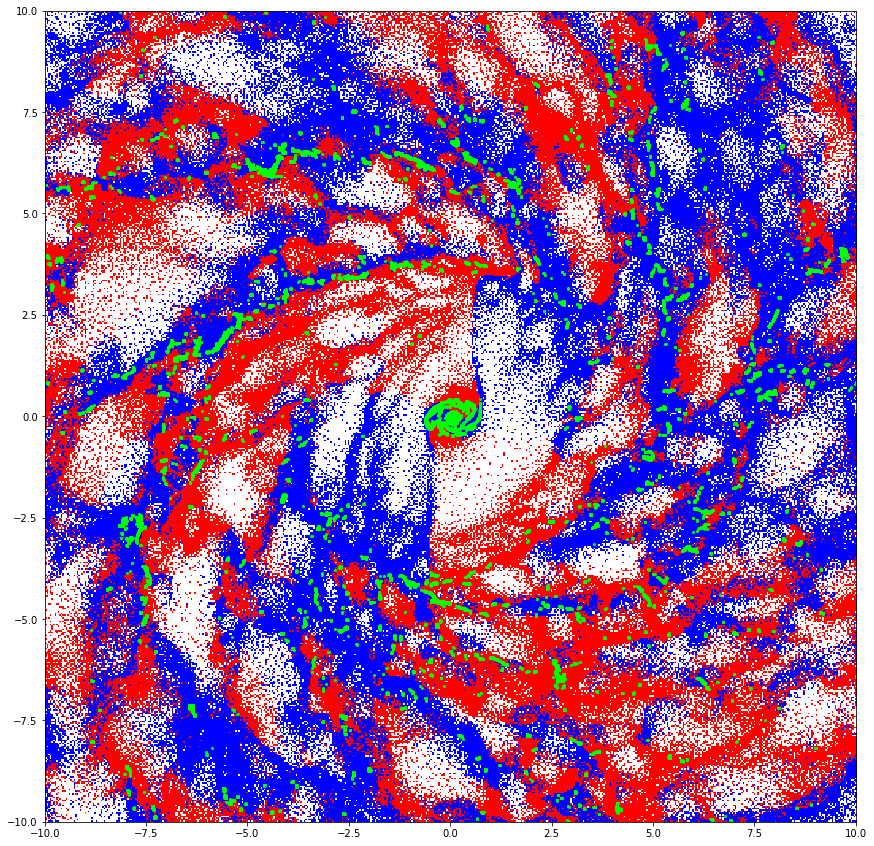

In [14]:
nres = 512

range_xy = [[-10, 10], [-10, 10]]

vmin = 0.005
vmax = 0.7

x = pos[:,0]
y = pos[:,1]

heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=vR)
heatmap_N, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

heatmap_xy /= heatmap_N

dx = (range_xy[0][1] - range_xy[0][0])/nres
dy = (range_xy[1][1] - range_xy[1][0])/nres

heatmap_xy /= dx * dy
print(np.max(heatmap_xy))

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=-50, vmax=50, cmap='bwr')

is_star_forming = sn.part0.sfr.value > 0.0
ax.scatter(pos[:,0][is_star_forming], pos[:,1][is_star_forming], s=4, c='lime')

ax.set_aspect('equal')
ax.set(xlim=range_xy[0], ylim=range_xy[1])
fig.tight_layout()

plt.show()


27.286632837355135


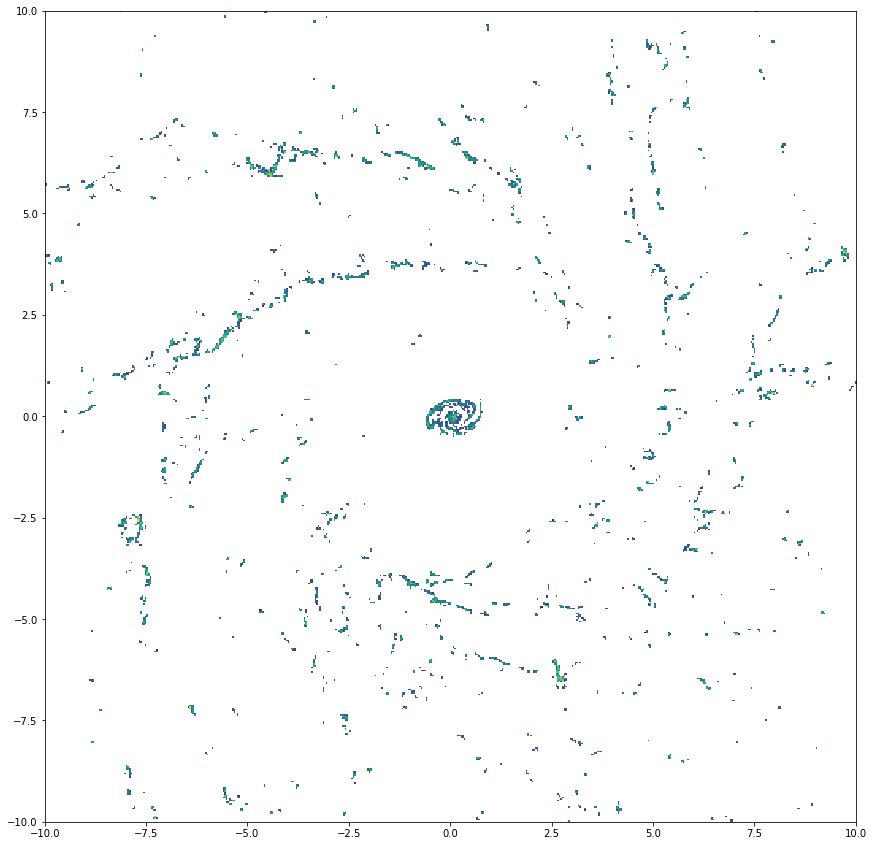

In [13]:
nres = 512

range_xy = [[-10, 10], [-10, 10]]

vmin = 0.005
vmax = 0.7

x = pos[:,0]
y = pos[:,1]
sfr = sn.part0.sfr.value
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=sfr)

dx = (range_xy[0][1] - range_xy[0][0])/nres
dy = (range_xy[1][1] - range_xy[1][0])/nres

heatmap_xy /= dx * dy
print(np.max(heatmap_xy))

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())#, vmin=-0.2, vmax=0.2, cmap='bwr')

ax.set_aspect('equal')
ax.set(xlim=range_xy[0], ylim=range_xy[1])
fig.tight_layout()

plt.show()


In [44]:
ball = np.linalg.norm(pos - np.array([-1.5, 3, 0]), axis=1) < 0.5

np.mean(vR[ball], axis=0)


50.75349074175595

In [21]:
center = np.array([200., 200., 200.])
ys_pos = sn.part4.pos.value - center
ys_vel = sn.part4.vel.value
ys_mass = sn.part4.mass.value

age = sn.Time.value - sn.part4.GFM_StellarFormationTime
key = age < 0.01

ys_pos = ys_pos[key]
ys_vel = ys_vel[key]
ys_mass = ys_mass[key]

ys_pos = rotate_pos(ys_pos, -bar_prop_S['bar_angle'][snap_idx] + np.pi/2.0)
ys_vel = rotate_pos(ys_vel, -bar_prop_S['bar_angle'][snap_idx] + np.pi/2.0)

ys_pos[:,0] = - ys_pos[:,0]
ys_vel[:,0] = - ys_vel[:,0]

ys_R = np.linalg.norm(ys_pos[:,:2], axis=1)
cphi = ys_pos[:,0] / ys_R
sphi = ys_pos[:,1] / ys_R

vphi = - ys_vel[:,0] * sphi + cphi * ys_vel[:,1]
vcirc = np.mean(vphi[np.logical_and(ys_R > 6, ys_R<10)])
print(vcirc)
# vcirc = 240
vx = - sphi * vcirc
vy = cphi * vcirc

ys_vel[:,0] -= vx
ys_vel[:,1] -= vy


-256.31185452443975


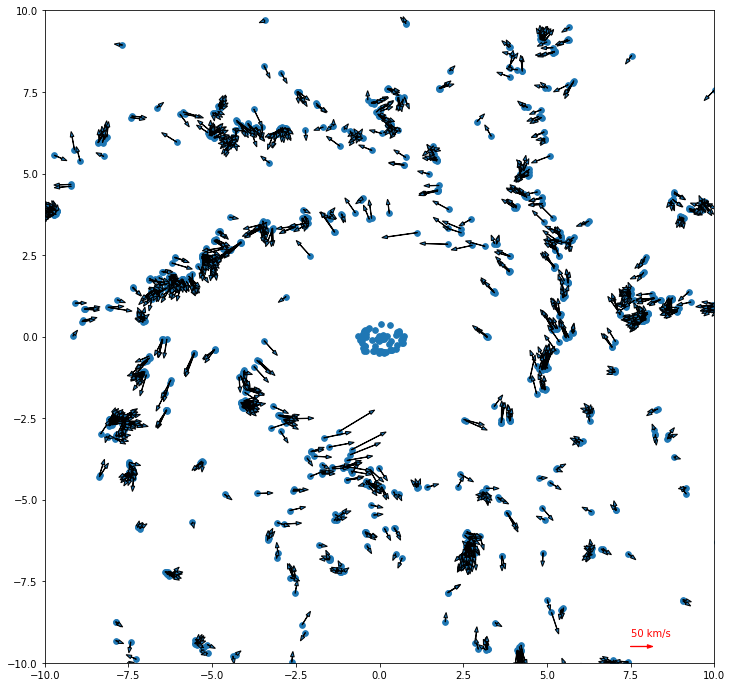

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

outR = np.where(ys_R > 3)[0]
ax.scatter(ys_pos[:,0], ys_pos[:,1], s=32)
for i in range(len(ys_pos)):
    if i not in outR:
        continue
    ax.arrow(ys_pos[i,0], ys_pos[i,1], ys_vel[i,0]/100.0, ys_vel[i,1]/100.0, width=0.01, head_width=0.11)

ax.arrow(7.5, -9.5, 50/100.0, 0.0, width=0.01, head_width=0.11, color='red')
ax.text(7.5, -9.2, '50 km/s', c='r')

ax.set(xlim=(-10, 10), ylim=(-10, 10))

plt.show()